# Aula 2 - Parte Prática - Policy Gradients 

## Introdução

Nesse segundo notebook vamos aprender ...

### Objetivos:

- Entender a abordagem de otimização de políticas como busca no espaço de parâmetros da política
- Implementar um primeiro agente baseado no algoritmo REINFORCE
- Familiarizar-se com a API básica de construção de modelos (i.e., redes neurais) em Keras
- Familiarizar-se com métodos de Deep Learning usando TensorFlow 2.X

### Imports

> **Atenção:** não se esqueça de executar todos os `imports` necessários antes prosseguir com o tutorial.

In [1]:
import gym

import tensorflow as tf
import tensorflow_probability as tfp

In [2]:
# sanity check
assert tf.__version__ == '2.1.0'
assert tf.executing_eagerly()

## 1. Implementando políticas estocásticas em tf.Keras 

In [3]:
tfd = tfp.distributions

### 1.1 Caso discreto

In [4]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, input_shape=(5,), activation="relu"),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(3),
    tfp.layers.DistributionLambda(lambda t: tfd.Categorical(logits=t))
])

In [5]:
inputs = tf.random.normal(shape=(10, 5))
print(inputs)

tf.Tensor(
[[ 1.0197699   0.47428548  0.2965943  -0.10242511 -0.5735167 ]
 [ 0.565398   -0.04325616 -1.1478148   1.5626593   1.6271482 ]
 [-0.31541196  1.1561725   1.1047056   0.6659174  -0.4729442 ]
 [-1.9021344  -1.041634   -0.3038097   0.3267942  -2.4408534 ]
 [ 0.09944467 -1.6871363   1.231891   -0.8362808   0.23534812]
 [ 0.42726743  0.9975547   0.2044676  -1.7461429  -0.28520787]
 [ 1.4809198   1.0324925  -0.5188921   1.1197615  -1.1958312 ]
 [-0.63057303 -0.07462202  0.28054234 -0.21744715  0.14993018]
 [-0.34556782  1.230658   -0.4019065  -1.5291711  -0.0617843 ]
 [ 0.46910807  1.6556784  -0.25092748 -1.4470996   0.48547304]], shape=(10, 5), dtype=float32)


In [6]:
dist = model(inputs)
print(dist)

tfp.distributions.Categorical("sequential_distribution_lambda_Categorical", batch_shape=[10], event_shape=[], dtype=int32)


In [7]:
sample = dist.sample()
print(sample)

tf.Tensor([2 2 0 1 0 2 1 1 1 0], shape=(10,), dtype=int32)


In [8]:
sample_log_prob = dist.log_prob(sample)
print(sample_log_prob)

tf.Tensor(
[-1.0460429  -1.0783268  -0.9896811  -0.78406465 -1.2145491  -1.0624999
 -1.39658    -1.251678   -1.6292527  -0.7932836 ], shape=(10,), dtype=float32)


In [59]:
def build_discrete_policy(obs_space, action_space, hidden_layers, activation):
    Input = tf.keras.Input
    Dense = tf.keras.layers.Dense
    DistributionLambda = tfp.layers.DistributionLambda
    Categorical = tfd.Categorical
    
    policy_net_layers = []

    policy_net_layers.append(Input(shape=obs_space.shape, name="Input"))

    for i, units in enumerate(hidden_layers):
        policy_net_layers.append(Dense(units=units, activation=activation, name=f"Hidden{i+1}"))
    
    policy_net_layers.append(Dense(units=action_space.n, name="Logits"))
    policy_net_layers.append(DistributionLambda(lambda t: Categorical(logits=t), name="Categorical"))
                                     
    return tf.keras.Sequential(policy_net_layers)


In [61]:
env = gym.make("MountainCar-v0")

hidden_layers = [64, 64]
activation = "relu"

policy = build_discrete_policy(env.observation_space, env.action_space, hidden_layers, activation)

obs = env.observation_space.sample()

action_dist = policy(obs[None,:])
print(action_dist)

action = action_dist.sample().numpy()
assert action[0] in env.action_space

tfp.distributions.Categorical("sequential_15_Categorical_Categorical", batch_shape=[1], event_shape=[], dtype=int32)


/Users/angelolovatto/anaconda3/envs/rlsummer/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


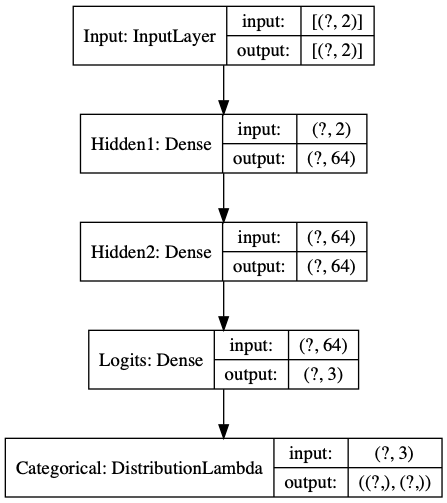

In [62]:
tf.keras.utils.plot_model(policy, show_shapes=True)

### 1.2 Caso contínuo 

In [11]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation="tanh", input_shape=(10,)),
    tf.keras.layers.Dense(128, activation="tanh"),
    tf.keras.layers.Dense(10),
    tfp.layers.DistributionLambda(lambda t: tfd.MultivariateNormalDiag(loc=t, scale_diag=[1e-2] * 10))
])

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


In [12]:
inputs = tf.random.normal(shape=(4, 10))
print(inputs)

tf.Tensor(
[[ 1.5546237   0.94584984 -0.30295444  1.1821576   0.46429217  0.81685746
  -1.136613   -0.63353306 -1.1625364   0.14177465]
 [-0.5683563   0.33984908  1.0811279  -0.47636017 -0.43675753  0.9557675
  -1.3628517  -0.117914   -0.7350723  -0.14375885]
 [ 0.26506996  1.2245876   0.26430196 -0.7895543   1.1732157   0.3945994
  -1.5037414   0.19365552 -1.3747582  -1.3010015 ]
 [-0.713999    0.08047012 -0.37626123 -0.79631215  0.6615652  -0.39082345
  -0.47354576 -0.08914193  0.7504426  -1.4283239 ]], shape=(4, 10), dtype=float32)


In [85]:
dist = model(inputs)
print(dist)

tfp.distributions.MultivariateNormalDiag("sequential_14_distribution_lambda_14_MultivariateNormalDiag", batch_shape=[4], event_shape=[10], dtype=float32)


In [86]:
sample = dist.sample()
print(sample)

tf.Tensor(
[[ 0.02107014  0.67111677 -0.05717062 -0.10963654  0.30163962 -0.20284596
  -0.31478062  0.4405437  -0.45328838  0.4712263 ]
 [ 0.7728581   0.47813922  0.01443296 -0.24912257 -0.9230962   0.01782654
  -0.25555795  0.18761869 -0.2212125   0.21795002]
 [ 0.2327961  -0.4189296   0.47730008  0.10519981 -0.3640216   0.29068133
   0.0499337  -0.77466166  0.03433217 -0.42330003]
 [-0.16805093  0.09478584  0.15372992  0.00448452  0.26795706 -0.2142506
  -0.00713969  0.39221483 -0.07863823  0.16443925]], shape=(4, 10), dtype=float32)


In [87]:
sample_log_prob = dist.log_prob(sample)
print(sample_log_prob)

tf.Tensor([31.728992 35.46901  32.874004 32.92938 ], shape=(4,), dtype=float32)


In [56]:
def build_continuous_policy(obs_space, action_space, hidden_layers, activation, scale_diag=1e-2):
    Input = tf.keras.Input
    Dense = tf.keras.layers.Dense
    DistributionLambda = tfp.layers.DistributionLambda
    MultivariateNormalDiag = tfd.MultivariateNormalDiag
    
    policy_net_layers = []
    
    policy_net_layers.append(Input(shape=obs_space.shape, name="Input"))

    for i, units in enumerate(hidden_layers):
        policy_net_layers.append(Dense(units=units, activation=activation, name=f"Hidden{i+1}"))

    policy_net_layers.append(Dense(units=action_space.shape[0], name="Params"))
    policy_net_layers.append(DistributionLambda(
        lambda t: MultivariateNormalDiag(loc=t, scale_diag=[scale_diag] * action_space.shape[0]),
        name="Gaussian"
    ))
                                     
    return tf.keras.Sequential(policy_net_layers)

In [57]:
env = gym.make("MountainCarContinuous-v0")

hidden_layers = [32, 32, 32]
activation = "elu"

policy = build_continuous_policy(env.observation_space, env.action_space, hidden_layers, activation)

obs = env.observation_space.sample()

action_dist = policy(obs[None,:])
print(action_dist)

action = action_dist.sample().numpy()
assert action[0] in env.action_space

tfp.distributions.MultivariateNormalDiag("sequential_14_Gaussian_MultivariateNormalDiag", batch_shape=[1], event_shape=[1], dtype=float32)


/Users/angelolovatto/anaconda3/envs/rlsummer/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


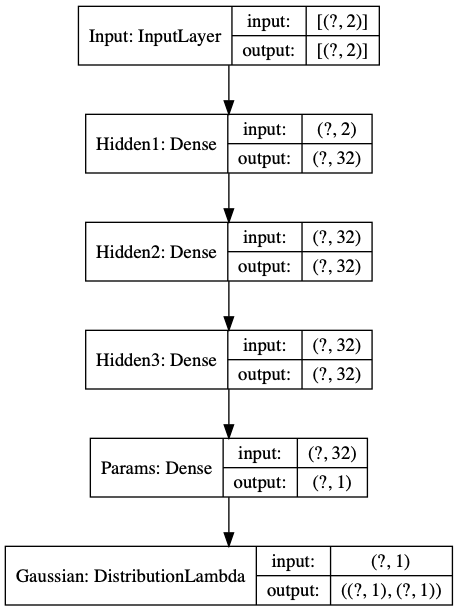

In [58]:
tf.keras.utils.plot_model(policy, show_shapes=True)

## 2. Função objetivo em Policy Gradients (*surrogate loss*) 

### 2.1 Calculando log-prob da escolha da ação 

### 2.2 Calculando retornos de episódios 

### 2.3 Implementação do *surrogate loss*: combinando log-prob e retornos 

## 3. Agente REINFORCE 

## 4. Treinamento do agente

## 5. Experimentos 